This is a baseline for the HTCV Sem

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import shutil

from data_loader import load_data_entries
from constants import *

In [2]:
train_data_entries = load_data_entries(data_type="train",percentage_as_str="10")
print(len(train_data_entries))
print(train_data_entries)

280
[('socal-fire_00000862_post_disaster.png', 3), ('hurricane-michael_00000504_post_disaster.png', 1), ('hurricane-florence_00000500_post_disaster.png', 3), ('midwest-flooding_00000264_post_disaster.png', 1), ('santa-rosa-wildfire_00000368_post_disaster.png', 1), ('hurricane-florence_00000218_post_disaster.png', 0), ('hurricane-florence_00000435_post_disaster.png', 1), ('hurricane-michael_00000322_post_disaster.png', 1), ('midwest-flooding_00000426_post_disaster.png', 1), ('hurricane-matthew_00000219_post_disaster.png', 3), ('santa-rosa-wildfire_00000351_post_disaster.png', 2), ('socal-fire_00000563_post_disaster.png', 0), ('socal-fire_00000367_post_disaster.png', 4), ('santa-rosa-wildfire_00000283_post_disaster.png', 2), ('hurricane-florence_00000022_post_disaster.png', 3), ('hurricane-florence_00000436_post_disaster.png', 3), ('socal-fire_00001178_post_disaster.png', 0), ('socal-fire_00000886_post_disaster.png', 2), ('socal-fire_00000073_post_disaster.png', 0), ('midwest-flooding_00

In [3]:
def visualize_data(idx, data_type, data):
    img_name = data[idx][0]
    img_path = os.path.join(DATASET_FOLDER_PATH,data_type,"images",img_name)
    img = Image.open(img_path)
    img.show()

In [4]:

# Define the ResNet model
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet18(weights=None)
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

# Create an instance of the ResNet classifier
num_classes = 5  # Number of output classes
model = ResNetClassifier(num_classes)

In [5]:
# Load and preprocess your dataset using torchvision.transforms
pre_norm_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the input image to match the expected size of ResNet (224x224)
    transforms.ToTensor()
])
# Calculate the mean and standard deviation of your dataset
path_to_dataset = os.path.join(DATASET_FOLDER_PATH,"train")
dataset = torchvision.datasets.ImageFolder(path_to_dataset, transform=pre_norm_transform)
data_point_names = np.array(train_data_entries)[:,0]

subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in data_point_names]
loader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=False)

mean = 0.0
std = 0.0
total_samples = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_samples += batch_samples

mean /= total_samples
std /= total_samples

# Update the normalization transform using your dataset's mean and standard deviation
transform = transforms.Compose([
    pre_norm_transform,
    transforms.Normalize(mean, std)
])

In [19]:
print(mean)
print(std)

tensor([0.3048, 0.3366, 0.2518])
tensor([0.1172, 0.1034, 0.0987])


tensor([0.3048, 0.3366, 0.2518])
tensor([0.1172, 0.1034, 0.0987])

In [6]:
# Example dataset loading using torchvision.datasets.ImageFolder
dataset = torchvision.datasets.ImageFolder(path_to_dataset, transform=transform)
subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in data_point_names]
dataloader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=True)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [21]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")

# Save the trained model
torch.save(model.state_dict(), 'resnet_classifier.pth')


Epoch 1/10, Loss: 13.578254580497742
Epoch 2/10, Loss: 12.578863620758057
Epoch 3/10, Loss: 12.22071897983551
Epoch 4/10, Loss: 11.849748492240906
Epoch 5/10, Loss: 11.631107091903687
Epoch 6/10, Loss: 11.142237544059753
Epoch 7/10, Loss: 10.742456674575806
Epoch 8/10, Loss: 10.35885339975357
Epoch 9/10, Loss: 9.961780786514282
Epoch 10/10, Loss: 9.88847291469574


In [13]:
# Define the evaluation function
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Create an instance of the ResNetClassifier
model = ResNetClassifier(num_classes)

# Load the saved model state dictionary
model.load_state_dict(torch.load('resnet_classifier.pth'))

# Set the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the test dataset
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join("..","dataset","test"), transform=transform)

# Create the test dataloader
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Move the model to the device
model.to(device)

# Evaluate the model
accuracy = evaluate_model(model, test_dataloader)

# Print the accuracy
print(f"Accuracy: {accuracy}")


Accuracy: 0.5273311897106109


first run:
Accuracy: 0.5273311897106109

In [22]:
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Initialize the lists to store the true and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(confusion_mat)



Confusion Matrix:
[[115  75   0   4   0]
 [ 36 348   0  13   0]
 [ 20 114   0   4   0]
 [ 20  74   1  24   0]
 [ 21  59   0   5   0]]


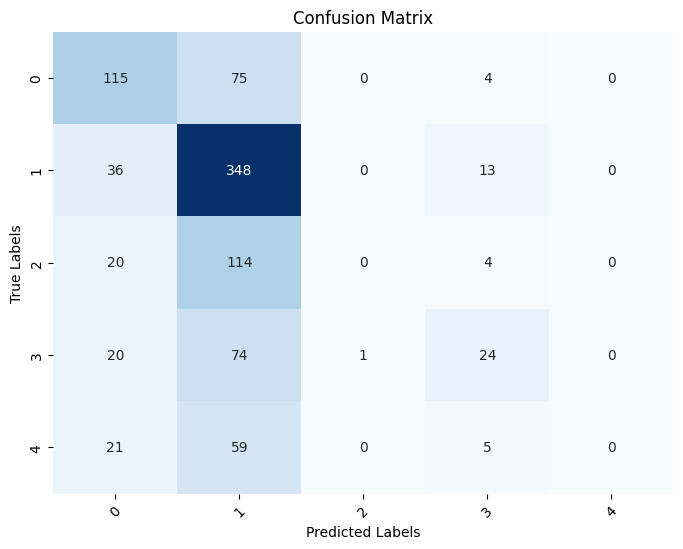

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Get the class labels
class_labels = test_dataset.classes

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels and title
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [7]:
# Train the model

model.train()
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")

# Save the trained model
torch.save(model.state_dict(), 'resnet_classifier_50epoch.pth')



Epoch 1/50, Loss: 13.49449098110199
Epoch 2/50, Loss: 12.4426908493042
Epoch 3/50, Loss: 11.951421976089478
Epoch 4/50, Loss: 11.724496722221375
Epoch 5/50, Loss: 11.270372033119202
Epoch 6/50, Loss: 10.980766773223877
Epoch 7/50, Loss: 10.71269941329956
Epoch 8/50, Loss: 10.297298669815063
Epoch 9/50, Loss: 10.000053524971008
Epoch 10/50, Loss: 9.837932407855988
Epoch 11/50, Loss: 9.347665429115295
Epoch 12/50, Loss: 9.070797860622406
Epoch 13/50, Loss: 8.915954172611237
Epoch 14/50, Loss: 8.41830188035965
Epoch 15/50, Loss: 8.198334217071533
Epoch 16/50, Loss: 7.7392688393592834
Epoch 17/50, Loss: 7.290441453456879
Epoch 18/50, Loss: 7.161375164985657
Epoch 19/50, Loss: 6.979715406894684
Epoch 20/50, Loss: 6.254225790500641
Epoch 21/50, Loss: 6.0786339938640594
Epoch 22/50, Loss: 5.457643300294876
Epoch 23/50, Loss: 5.794948220252991
Epoch 24/50, Loss: 5.377321422100067
Epoch 25/50, Loss: 5.019159197807312
Epoch 26/50, Loss: 4.274088561534882
Epoch 27/50, Loss: 4.282565534114838
Epoc

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()

test_dataset = torchvision.datasets.ImageFolder(root=os.path.join("..","dataset","test"), transform=transform)

# Create the test dataloader
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the lists to store the true and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels, normalize="true")

print("Confusion Matrix:")
print(confusion_mat)

# Get the class labels
class_labels = test_dataset.classes



Confusion Matrix:
[[0.69587629 0.22164948 0.02061856 0.03092784 0.03092784]
 [0.1209068  0.74811083 0.03526448 0.0604534  0.03526448]
 [0.16666667 0.60869565 0.08695652 0.11594203 0.02173913]
 [0.20168067 0.29411765 0.07563025 0.36134454 0.06722689]
 [0.24705882 0.29411765 0.08235294 0.23529412 0.14117647]]


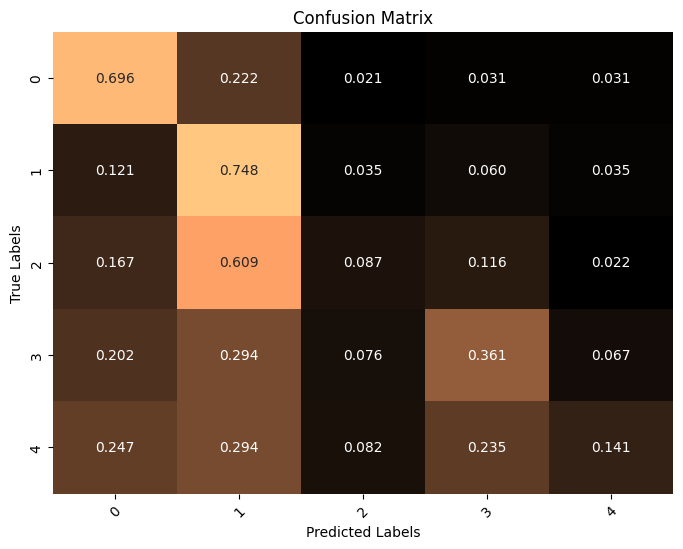

In [30]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt=".3f", cmap="copper", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels and title
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()
